In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix


## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## Neural network model

In [3]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
        
        print("Depth of the network = number of hidden layers + 1:", D)
        
        for i in range(self.D):
            
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            
            stdv = 2/ np.sqrt(layers_dim[i])
            
            weight = (weight-0.5)*stdv

            weight.requires_grad = True
            
            self.weights.append(weight)
       
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [4]:
input_dim = 784
output_dim = 10
hidden_dim1 = 600

D = 2

# initialize the model
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

Depth of the network = number of hidden layers + 1: 2


## Training parameters

In [5]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

## Training loop

In [6]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []
MSE_tab = []
R_tab = []

In [7]:
batch_size: int = 1000 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        # reset the gradients from previouis iteration
        optimizer.zero_grad()

        # pass through the network
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)

        # backward pass thorught the network
        loss.backward()

        # apply the gradients
        optimizer.step()     

    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )

    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())


    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            # pass through the network            
            output: torch.Tensor = model(x)
            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))

        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            # pass through the network            
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))

    ########################################################################
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]

    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
    
    term_I_tab.append(term_1)
    term_II_tab.append(term_2)
    term_IV_tab.append(term_4)
    R_tab.append(R)

    term_1 = round(float(term_1), 6)
    term_2 = round(term_2, 6)

    check = round(1+ term_2 - term_4, 6)
    check2 = round(1+ term_1 + term_2 - term_4, 6)

    print(f"{e}\t{loss} \t term1: {term_1}, \t term2: {term_2} \t {check}\t {check2}")   



0	0.09373711794614792 	 term1: 0.074118, 	 term2: 0.402069 	 1.136747	 1.210865
1	0.07317829877138138 	 term1: 0.019884, 	 term2: 0.290174 	 0.901534	 0.921418
2	0.06386082619428635 	 term1: 0.005784, 	 term2: 0.2367 	 0.776099	 0.781883
3	0.058471065014600754 	 term1: 0.002077, 	 term2: 0.206698 	 0.699778	 0.701855
4	0.054946839809417725 	 term1: 0.001748, 	 term2: 0.1884 	 0.649094	 0.650842
5	0.05245493724942207 	 term1: 0.002611, 	 term2: 0.176564 	 0.613274	 0.615885
6	0.05059216916561127 	 term1: 0.003878, 	 term2: 0.168543 	 0.58674	 0.590618
7	0.049140509217977524 	 term1: 0.005242, 	 term2: 0.162895 	 0.566347	 0.571589
8	0.04797232523560524 	 term1: 0.006579, 	 term2: 0.158785 	 0.5502	 0.556779
9	0.04700819030404091 	 term1: 0.007842, 	 term2: 0.155709 	 0.5371	 0.544942
10	0.04619617760181427 	 term1: 0.009014, 	 term2: 0.153348 	 0.526252	 0.535266
11	0.04550087824463844 	 term1: 0.010093, 	 term2: 0.151496 	 0.517113	 0.527206
12	0.04489734396338463 	 term1: 0.011084, 	 

102	0.03660665452480316 	 term1: 0.030897, 	 term2: 0.1429 	 0.409486	 0.440383
103	0.03658691421151161 	 term1: 0.030971, 	 term2: 0.14294 	 0.409252	 0.440223
104	0.03656743839383125 	 term1: 0.031045, 	 term2: 0.142981 	 0.409022	 0.440067
105	0.03654823824763298 	 term1: 0.031117, 	 term2: 0.143021 	 0.408795	 0.439912
106	0.0365292951464653 	 term1: 0.031189, 	 term2: 0.143062 	 0.408571	 0.43976
107	0.03651059791445732 	 term1: 0.03126, 	 term2: 0.143102 	 0.40835	 0.43961
108	0.03649216145277023 	 term1: 0.03133, 	 term2: 0.143143 	 0.408132	 0.439462
109	0.03647396340966225 	 term1: 0.031399, 	 term2: 0.143184 	 0.407918	 0.439317
110	0.03645600005984306 	 term1: 0.031468, 	 term2: 0.143225 	 0.407706	 0.439174
111	0.036438267678022385 	 term1: 0.031536, 	 term2: 0.143267 	 0.407498	 0.439034
112	0.03642076626420021 	 term1: 0.031604, 	 term2: 0.143308 	 0.407292	 0.438896
113	0.03640348091721535 	 term1: 0.031671, 	 term2: 0.14335 	 0.407089	 0.43876
114	0.036386411637067795 	

203	0.03539566695690155 	 term1: 0.035934, 	 term2: 0.147205 	 0.395818	 0.431752
204	0.03538825362920761 	 term1: 0.035968, 	 term2: 0.147246 	 0.39574	 0.431708
205	0.03538089618086815 	 term1: 0.036003, 	 term2: 0.147288 	 0.395664	 0.431667
206	0.03537358343601227 	 term1: 0.036037, 	 term2: 0.147329 	 0.395588	 0.431625
207	0.03536633402109146 	 term1: 0.036071, 	 term2: 0.14737 	 0.395512	 0.431583
208	0.035359129309654236 	 term1: 0.036104, 	 term2: 0.147411 	 0.395437	 0.431541
209	0.03535197675228119 	 term1: 0.036138, 	 term2: 0.147452 	 0.395363	 0.431501
210	0.03534487634897232 	 term1: 0.036171, 	 term2: 0.147493 	 0.395289	 0.43146
211	0.03533782437443733 	 term1: 0.036204, 	 term2: 0.147534 	 0.395216	 0.43142
212	0.03533082455396652 	 term1: 0.036237, 	 term2: 0.147575 	 0.395144	 0.431381
213	0.035323865711688995 	 term1: 0.03627, 	 term2: 0.147615 	 0.395071	 0.431341
214	0.03531695902347565 	 term1: 0.036302, 	 term2: 0.147656 	 0.395	 0.431302
215	0.0353101044893264

304	0.034845124930143356 	 term1: 0.038642, 	 term2: 0.150961 	 0.390349	 0.428991
305	0.0348411425948143 	 term1: 0.038663, 	 term2: 0.150994 	 0.390312	 0.428975
306	0.034837186336517334 	 term1: 0.038684, 	 term2: 0.151026 	 0.390274	 0.428958
307	0.03483324497938156 	 term1: 0.038704, 	 term2: 0.151059 	 0.390238	 0.428942
308	0.034829333424568176 	 term1: 0.038725, 	 term2: 0.151091 	 0.390201	 0.428926
309	0.034825436770915985 	 term1: 0.038745, 	 term2: 0.151123 	 0.390164	 0.428909
310	0.034821562469005585 	 term1: 0.038765, 	 term2: 0.151156 	 0.390129	 0.428894
311	0.034817710518836975 	 term1: 0.038786, 	 term2: 0.151188 	 0.390093	 0.428879
312	0.034813880920410156 	 term1: 0.038806, 	 term2: 0.15122 	 0.390057	 0.428863
313	0.03481006622314453 	 term1: 0.038826, 	 term2: 0.151252 	 0.390021	 0.428847
314	0.0348062701523304 	 term1: 0.038846, 	 term2: 0.151284 	 0.389986	 0.428832
315	0.03480249643325806 	 term1: 0.038866, 	 term2: 0.151316 	 0.389951	 0.428817
316	0.034798

405	0.034528832882642746 	 term1: 0.040362, 	 term2: 0.153842 	 0.387482	 0.427844
406	0.03452638164162636 	 term1: 0.040375, 	 term2: 0.153867 	 0.387461	 0.427836
407	0.03452394902706146 	 term1: 0.040389, 	 term2: 0.153892 	 0.38744	 0.427829
408	0.034521523863077164 	 term1: 0.040403, 	 term2: 0.153916 	 0.387419	 0.427822
409	0.03451911360025406 	 term1: 0.040417, 	 term2: 0.153941 	 0.387398	 0.427815
410	0.03451671078801155 	 term1: 0.04043, 	 term2: 0.153965 	 0.387377	 0.427807
411	0.03451431542634964 	 term1: 0.040444, 	 term2: 0.153989 	 0.387356	 0.4278
412	0.03451193869113922 	 term1: 0.040458, 	 term2: 0.154013 	 0.387335	 0.427793
413	0.0345095656812191 	 term1: 0.040471, 	 term2: 0.154038 	 0.387315	 0.427786
414	0.03450720012187958 	 term1: 0.040485, 	 term2: 0.154062 	 0.387294	 0.427779
415	0.03450484946370125 	 term1: 0.040498, 	 term2: 0.154086 	 0.387274	 0.427772
416	0.034502509981393814 	 term1: 0.040511, 	 term2: 0.15411 	 0.387253	 0.427764
417	0.0345001816749

506	0.03432657942175865 	 term1: 0.041542, 	 term2: 0.156017 	 0.385752	 0.427294
507	0.034324951469898224 	 term1: 0.041552, 	 term2: 0.156036 	 0.385738	 0.42729
508	0.034323327243328094 	 term1: 0.041562, 	 term2: 0.156054 	 0.385724	 0.427286
509	0.03432171046733856 	 term1: 0.041572, 	 term2: 0.156073 	 0.385711	 0.427283
510	0.03432009741663933 	 term1: 0.041581, 	 term2: 0.156092 	 0.385698	 0.427279
511	0.03431849181652069 	 term1: 0.041591, 	 term2: 0.15611 	 0.385684	 0.427275
512	0.03431689366698265 	 term1: 0.041601, 	 term2: 0.156129 	 0.385671	 0.427272
513	0.03431529924273491 	 term1: 0.04161, 	 term2: 0.156147 	 0.385657	 0.427267
514	0.03431371599435806 	 term1: 0.04162, 	 term2: 0.156165 	 0.385644	 0.427264
515	0.03431212902069092 	 term1: 0.041629, 	 term2: 0.156184 	 0.385631	 0.42726
516	0.03431055694818497 	 term1: 0.041639, 	 term2: 0.156202 	 0.385618	 0.427257
517	0.03430898115038872 	 term1: 0.041648, 	 term2: 0.15622 	 0.385604	 0.427252
518	0.03430742025375

607	0.034188006073236465 	 term1: 0.042397, 	 term2: 0.15768 	 0.384605	 0.427002
608	0.03418685868382454 	 term1: 0.042404, 	 term2: 0.157694 	 0.384595	 0.426999
609	0.034185707569122314 	 term1: 0.042411, 	 term2: 0.157709 	 0.384587	 0.426998
610	0.034184567630290985 	 term1: 0.042418, 	 term2: 0.157723 	 0.384577	 0.426995
611	0.034183431416749954 	 term1: 0.042426, 	 term2: 0.157738 	 0.384568	 0.426994
612	0.03418229520320892 	 term1: 0.042433, 	 term2: 0.157752 	 0.384559	 0.426992
613	0.03418116271495819 	 term1: 0.04244, 	 term2: 0.157766 	 0.384549	 0.426989
614	0.034180037677288055 	 term1: 0.042447, 	 term2: 0.15778 	 0.38454	 0.426987
615	0.03417892009019852 	 term1: 0.042454, 	 term2: 0.157794 	 0.38453	 0.426984
616	0.03417779132723808 	 term1: 0.042461, 	 term2: 0.157809 	 0.384522	 0.426983
617	0.03417668119072914 	 term1: 0.042468, 	 term2: 0.157823 	 0.384513	 0.426981
618	0.0341755636036396 	 term1: 0.042476, 	 term2: 0.157837 	 0.384504	 0.42698
619	0.034174457192

708	0.034088194370269775 	 term1: 0.043041, 	 term2: 0.158977 	 0.383794	 0.426835
709	0.034087348729372025 	 term1: 0.043046, 	 term2: 0.158988 	 0.383787	 0.426833
710	0.03408650681376457 	 term1: 0.043052, 	 term2: 0.159 	 0.383781	 0.426833
711	0.03408566117286682 	 term1: 0.043058, 	 term2: 0.159011 	 0.383773	 0.426831
712	0.03408482298254967 	 term1: 0.043063, 	 term2: 0.159022 	 0.383766	 0.426829
713	0.03408399224281311 	 term1: 0.043069, 	 term2: 0.159034 	 0.38376	 0.426829
714	0.034083154052495956 	 term1: 0.043074, 	 term2: 0.159045 	 0.383753	 0.426827
715	0.0340823233127594 	 term1: 0.04308, 	 term2: 0.159056 	 0.383746	 0.426826
716	0.03408149257302284 	 term1: 0.043085, 	 term2: 0.159067 	 0.383739	 0.426824
717	0.034080665558576584 	 term1: 0.043091, 	 term2: 0.159079 	 0.383734	 0.426825
718	0.034079842269420624 	 term1: 0.043096, 	 term2: 0.15909 	 0.383727	 0.426823
719	0.03407902270555496 	 term1: 0.043101, 	 term2: 0.159101 	 0.38372	 0.426821
720	0.0340782031416

809	0.03401350602507591 	 term1: 0.043542, 	 term2: 0.16001 	 0.383191	 0.426733
810	0.03401286527514458 	 term1: 0.043546, 	 term2: 0.160019 	 0.383186	 0.426732
811	0.03401222452521324 	 term1: 0.043551, 	 term2: 0.160028 	 0.38318	 0.426731
812	0.03401158004999161 	 term1: 0.043555, 	 term2: 0.160037 	 0.383175	 0.42673
813	0.03401094302535057 	 term1: 0.04356, 	 term2: 0.160046 	 0.38317	 0.42673
814	0.034010302275419235 	 term1: 0.043564, 	 term2: 0.160055 	 0.383165	 0.426729
815	0.034009672701358795 	 term1: 0.043568, 	 term2: 0.160064 	 0.38316	 0.426728
816	0.03400903567671776 	 term1: 0.043573, 	 term2: 0.160073 	 0.383154	 0.426727
817	0.03400840610265732 	 term1: 0.043577, 	 term2: 0.160083 	 0.38315	 0.426727
818	0.03400777652859688 	 term1: 0.043581, 	 term2: 0.160092 	 0.383145	 0.426726
819	0.03400714322924614 	 term1: 0.043586, 	 term2: 0.160101 	 0.38314	 0.426726
820	0.034006517380476 	 term1: 0.04359, 	 term2: 0.160109 	 0.383134	 0.426724
821	0.034005891531705856 	

910	0.03395591303706169 	 term1: 0.043942, 	 term2: 0.160848 	 0.382725	 0.426667
911	0.0339554138481617 	 term1: 0.043946, 	 term2: 0.160855 	 0.382721	 0.426667
912	0.033954910933971405 	 term1: 0.043949, 	 term2: 0.160863 	 0.382717	 0.426666
913	0.03395440801978111 	 term1: 0.043953, 	 term2: 0.16087 	 0.382713	 0.426666
914	0.03395390510559082 	 term1: 0.043957, 	 term2: 0.160878 	 0.382709	 0.426666
915	0.033953405916690826 	 term1: 0.04396, 	 term2: 0.160885 	 0.382705	 0.426665
916	0.03395291045308113 	 term1: 0.043964, 	 term2: 0.160892 	 0.3827	 0.426664
917	0.033952414989471436 	 term1: 0.043967, 	 term2: 0.1609 	 0.382697	 0.426664
918	0.03395191952586174 	 term1: 0.043971, 	 term2: 0.160907 	 0.382692	 0.426663
919	0.033951424062252045 	 term1: 0.043974, 	 term2: 0.160915 	 0.382689	 0.426663
920	0.03395093232393265 	 term1: 0.043978, 	 term2: 0.160922 	 0.382685	 0.426663
921	0.03395044431090355 	 term1: 0.043981, 	 term2: 0.160929 	 0.38268	 0.426661
922	0.03394995257258

1011	0.03391041234135628 	 term1: 0.044269, 	 term2: 0.161539 	 0.382354	 0.426623
1012	0.033910006284713745 	 term1: 0.044272, 	 term2: 0.161545 	 0.382351	 0.426623
1013	0.03390960767865181 	 term1: 0.044275, 	 term2: 0.161551 	 0.382347	 0.426622
1014	0.033909205347299576 	 term1: 0.044278, 	 term2: 0.161557 	 0.382344	 0.426622
1015	0.03390881046652794 	 term1: 0.044281, 	 term2: 0.161564 	 0.382341	 0.426622
1016	0.033908411860466 	 term1: 0.044284, 	 term2: 0.16157 	 0.382338	 0.426622
1017	0.03390801325440407 	 term1: 0.044287, 	 term2: 0.161576 	 0.382334	 0.426621
1018	0.03390761464834213 	 term1: 0.044289, 	 term2: 0.161582 	 0.382331	 0.42662
1019	0.033907219767570496 	 term1: 0.044292, 	 term2: 0.161588 	 0.382327	 0.426619
1020	0.03390682861208916 	 term1: 0.044295, 	 term2: 0.161595 	 0.382325	 0.42662
1021	0.03390642628073692 	 term1: 0.044298, 	 term2: 0.161601 	 0.382322	 0.42662
1022	0.033906035125255585 	 term1: 0.044301, 	 term2: 0.161607 	 0.382318	 0.426619
1023	0

1110	0.03387438878417015 	 term1: 0.044535, 	 term2: 0.162107 	 0.382056	 0.426591
1111	0.033874060958623886 	 term1: 0.044538, 	 term2: 0.162112 	 0.382053	 0.426591
1112	0.03387373313307762 	 term1: 0.04454, 	 term2: 0.162118 	 0.382051	 0.426591
1113	0.03387340158224106 	 term1: 0.044543, 	 term2: 0.162123 	 0.382048	 0.426591
1114	0.03387307748198509 	 term1: 0.044545, 	 term2: 0.162128 	 0.382045	 0.42659
1115	0.033872753381729126 	 term1: 0.044548, 	 term2: 0.162133 	 0.382042	 0.42659
1116	0.03387242555618286 	 term1: 0.04455, 	 term2: 0.162139 	 0.382041	 0.426591
1117	0.033872105181217194 	 term1: 0.044553, 	 term2: 0.162144 	 0.382038	 0.426591
1118	0.03387178108096123 	 term1: 0.044555, 	 term2: 0.162149 	 0.382035	 0.42659
1119	0.03387145325541496 	 term1: 0.044557, 	 term2: 0.162154 	 0.382032	 0.426589
1120	0.033871132880449295 	 term1: 0.04456, 	 term2: 0.162159 	 0.382029	 0.426589
1121	0.03387080878019333 	 term1: 0.044562, 	 term2: 0.162165 	 0.382027	 0.426589
1122	0

1209	0.03384474664926529 	 term1: 0.044761, 	 term2: 0.16259 	 0.381807	 0.426568
1210	0.0338444747030735 	 term1: 0.044763, 	 term2: 0.162595 	 0.381805	 0.426568
1211	0.033844202756881714 	 term1: 0.044765, 	 term2: 0.1626 	 0.381804	 0.426569
1212	0.033843934535980225 	 term1: 0.044767, 	 term2: 0.162604 	 0.381801	 0.426568
1213	0.03384366258978844 	 term1: 0.044769, 	 term2: 0.162609 	 0.381799	 0.426568
1214	0.03384339436888695 	 term1: 0.044771, 	 term2: 0.162613 	 0.381796	 0.426567
1215	0.03384312614798546 	 term1: 0.044773, 	 term2: 0.162617 	 0.381793	 0.426566
1216	0.03384285420179367 	 term1: 0.044775, 	 term2: 0.162622 	 0.381792	 0.426567
1217	0.03384258598089218 	 term1: 0.044778, 	 term2: 0.162626 	 0.381789	 0.426567
1218	0.03384231775999069 	 term1: 0.04478, 	 term2: 0.162631 	 0.381787	 0.426567
1219	0.0338420495390892 	 term1: 0.044782, 	 term2: 0.162635 	 0.381784	 0.426566
1220	0.033841781318187714 	 term1: 0.044784, 	 term2: 0.16264 	 0.381783	 0.426567
1221	0.0

1308	0.0338200181722641 	 term1: 0.044954, 	 term2: 0.163006 	 0.381596	 0.42655
1309	0.03381979838013649 	 term1: 0.044956, 	 term2: 0.16301 	 0.381594	 0.42655
1310	0.03381956368684769 	 term1: 0.044958, 	 term2: 0.163014 	 0.381592	 0.42655
1311	0.03381933644413948 	 term1: 0.04496, 	 term2: 0.163018 	 0.38159	 0.42655
1312	0.03381911292672157 	 term1: 0.044961, 	 term2: 0.163022 	 0.381588	 0.426549
1313	0.03381888568401337 	 term1: 0.044963, 	 term2: 0.163026 	 0.381586	 0.426549
1314	0.03381865844130516 	 term1: 0.044965, 	 term2: 0.16303 	 0.381585	 0.42655
1315	0.03381843492388725 	 term1: 0.044967, 	 term2: 0.163034 	 0.381583	 0.42655
1316	0.03381820768117905 	 term1: 0.044969, 	 term2: 0.163038 	 0.381581	 0.42655
1317	0.03381798043847084 	 term1: 0.04497, 	 term2: 0.163041 	 0.381578	 0.426548
1318	0.033817753195762634 	 term1: 0.044972, 	 term2: 0.163045 	 0.381576	 0.426548
1319	0.03381752967834473 	 term1: 0.044974, 	 term2: 0.163049 	 0.381574	 0.426548
1320	0.033817306

1408	0.033798959106206894 	 term1: 0.045123, 	 term2: 0.163371 	 0.381412	 0.426535
1409	0.033798765391111374 	 term1: 0.045125, 	 term2: 0.163375 	 0.381411	 0.426536
1410	0.033798571676015854 	 term1: 0.045126, 	 term2: 0.163378 	 0.381409	 0.426535
1411	0.033798377960920334 	 term1: 0.045128, 	 term2: 0.163382 	 0.381407	 0.426535
1412	0.03379818797111511 	 term1: 0.045129, 	 term2: 0.163385 	 0.381405	 0.426534
1413	0.033797990530729294 	 term1: 0.045131, 	 term2: 0.163388 	 0.381403	 0.426534
1414	0.03379780054092407 	 term1: 0.045133, 	 term2: 0.163392 	 0.381402	 0.426535
1415	0.03379761055111885 	 term1: 0.045134, 	 term2: 0.163395 	 0.3814	 0.426534
1416	0.03379741683602333 	 term1: 0.045136, 	 term2: 0.163398 	 0.381398	 0.426534
1417	0.03379722312092781 	 term1: 0.045137, 	 term2: 0.163402 	 0.381397	 0.426534
1418	0.03379703685641289 	 term1: 0.045139, 	 term2: 0.163405 	 0.381395	 0.426534
1419	0.03379683941602707 	 term1: 0.04514, 	 term2: 0.163409 	 0.381394	 0.426534
14

1507	0.03378117457032204 	 term1: 0.045269, 	 term2: 0.163688 	 0.381253	 0.426522
1508	0.033781006932258606 	 term1: 0.045271, 	 term2: 0.163691 	 0.381252	 0.426523
1509	0.033780843019485474 	 term1: 0.045272, 	 term2: 0.163694 	 0.38125	 0.426522
1510	0.03378067538142204 	 term1: 0.045274, 	 term2: 0.163697 	 0.381249	 0.426523
1511	0.03378051519393921 	 term1: 0.045275, 	 term2: 0.1637 	 0.381248	 0.426523
1512	0.03378034755587578 	 term1: 0.045276, 	 term2: 0.163703 	 0.381246	 0.426522
1513	0.033780183643102646 	 term1: 0.045278, 	 term2: 0.163706 	 0.381245	 0.426523
1514	0.033780016005039215 	 term1: 0.045279, 	 term2: 0.163709 	 0.381243	 0.426522
1515	0.03377985209226608 	 term1: 0.04528, 	 term2: 0.163712 	 0.381242	 0.426522
1516	0.03377969190478325 	 term1: 0.045282, 	 term2: 0.163715 	 0.38124	 0.426522
1517	0.03377952426671982 	 term1: 0.045283, 	 term2: 0.163718 	 0.381239	 0.426522
1518	0.03377935662865639 	 term1: 0.045285, 	 term2: 0.163721 	 0.381237	 0.426522
1519	

1606	0.03376585990190506 	 term1: 0.045399, 	 term2: 0.163968 	 0.381113	 0.426512
1607	0.03376571834087372 	 term1: 0.0454, 	 term2: 0.163971 	 0.381113	 0.426513
1608	0.03376557677984238 	 term1: 0.045401, 	 term2: 0.163973 	 0.381111	 0.426512
1609	0.03376543149352074 	 term1: 0.045402, 	 term2: 0.163976 	 0.38111	 0.426512
1610	0.033765289932489395 	 term1: 0.045404, 	 term2: 0.163979 	 0.381109	 0.426513
1611	0.033765144646167755 	 term1: 0.045405, 	 term2: 0.163981 	 0.381107	 0.426512
1612	0.033764999359846115 	 term1: 0.045406, 	 term2: 0.163984 	 0.381106	 0.426512
1613	0.03376486152410507 	 term1: 0.045407, 	 term2: 0.163987 	 0.381105	 0.426512
1614	0.03376471623778343 	 term1: 0.045408, 	 term2: 0.163989 	 0.381103	 0.426511
1615	0.03376457095146179 	 term1: 0.04541, 	 term2: 0.163992 	 0.381102	 0.426512
1616	0.03376443311572075 	 term1: 0.045411, 	 term2: 0.163995 	 0.381101	 0.426512
1617	0.03376428782939911 	 term1: 0.045412, 	 term2: 0.163997 	 0.381099	 0.426511
1618	

1706	0.0337524451315403 	 term1: 0.045515, 	 term2: 0.16422 	 0.380988	 0.426503
1707	0.03375231474637985 	 term1: 0.045516, 	 term2: 0.164222 	 0.380986	 0.426502
1708	0.0337521918118 	 term1: 0.045517, 	 term2: 0.164225 	 0.380986	 0.426503
1709	0.033752065151929855 	 term1: 0.045518, 	 term2: 0.164227 	 0.380984	 0.426502
1710	0.03375193849205971 	 term1: 0.045519, 	 term2: 0.16423 	 0.380984	 0.426503
1711	0.03375181555747986 	 term1: 0.04552, 	 term2: 0.164232 	 0.380982	 0.426502
1712	0.03375168889760971 	 term1: 0.045521, 	 term2: 0.164234 	 0.380981	 0.426502
1713	0.03375156968832016 	 term1: 0.045522, 	 term2: 0.164237 	 0.38098	 0.426502
1714	0.03375144675374031 	 term1: 0.045524, 	 term2: 0.164239 	 0.380979	 0.426503
1715	0.03375132009387016 	 term1: 0.045525, 	 term2: 0.164241 	 0.380977	 0.426502
1716	0.03375120088458061 	 term1: 0.045526, 	 term2: 0.164244 	 0.380977	 0.426503
1717	0.033751074224710464 	 term1: 0.045527, 	 term2: 0.164246 	 0.380975	 0.426502
1718	0.0337

1806	0.03374071791768074 	 term1: 0.045619, 	 term2: 0.164446 	 0.380876	 0.426495
1807	0.033740606158971786 	 term1: 0.04562, 	 term2: 0.164448 	 0.380875	 0.426495
1808	0.03374049812555313 	 term1: 0.045621, 	 term2: 0.16445 	 0.380874	 0.426495
1809	0.03374038636684418 	 term1: 0.045622, 	 term2: 0.164452 	 0.380873	 0.426495
1810	0.03374027833342552 	 term1: 0.045623, 	 term2: 0.164454 	 0.380871	 0.426494
1811	0.033740170300006866 	 term1: 0.045624, 	 term2: 0.164456 	 0.38087	 0.426494
1812	0.03374005854129791 	 term1: 0.045625, 	 term2: 0.164459 	 0.38087	 0.426495
1813	0.03373995050787926 	 term1: 0.045626, 	 term2: 0.164461 	 0.380869	 0.426495
1814	0.0337398424744606 	 term1: 0.045627, 	 term2: 0.164463 	 0.380868	 0.426495
1815	0.03373973071575165 	 term1: 0.045628, 	 term2: 0.164465 	 0.380866	 0.426494
1816	0.03373962268233299 	 term1: 0.045628, 	 term2: 0.164467 	 0.380865	 0.426493
1817	0.033739518374204636 	 term1: 0.045629, 	 term2: 0.164469 	 0.380864	 0.426493
1818	0

1906	0.0337304025888443 	 term1: 0.045712, 	 term2: 0.164649 	 0.380774	 0.426486
1907	0.03373030573129654 	 term1: 0.045713, 	 term2: 0.164651 	 0.380774	 0.426487
1908	0.03373020514845848 	 term1: 0.045714, 	 term2: 0.164653 	 0.380773	 0.426487
1909	0.03373010829091072 	 term1: 0.045715, 	 term2: 0.164655 	 0.380772	 0.426487
1910	0.03373001143336296 	 term1: 0.045716, 	 term2: 0.164657 	 0.380771	 0.426487
1911	0.0337299145758152 	 term1: 0.045717, 	 term2: 0.164659 	 0.38077	 0.426487
1912	0.03372982144355774 	 term1: 0.045718, 	 term2: 0.164661 	 0.380769	 0.426487
1913	0.03372972831130028 	 term1: 0.045718, 	 term2: 0.164663 	 0.380768	 0.426486
1914	0.03372962772846222 	 term1: 0.045719, 	 term2: 0.164665 	 0.380767	 0.426486
1915	0.03372953087091446 	 term1: 0.04572, 	 term2: 0.164667 	 0.380766	 0.426486
1916	0.0337294340133667 	 term1: 0.045721, 	 term2: 0.164669 	 0.380766	 0.426487
1917	0.03372934088110924 	 term1: 0.045722, 	 term2: 0.164671 	 0.380765	 0.426487
1918	0.03

2005	0.033721357583999634 	 term1: 0.045796, 	 term2: 0.164832 	 0.380684	 0.42648
2006	0.03372127562761307 	 term1: 0.045797, 	 term2: 0.164834 	 0.380683	 0.42648
2007	0.0337211899459362 	 term1: 0.045798, 	 term2: 0.164836 	 0.380682	 0.42648
2008	0.03372110426425934 	 term1: 0.045799, 	 term2: 0.164838 	 0.380682	 0.426481
2009	0.03372101113200188 	 term1: 0.0458, 	 term2: 0.164839 	 0.38068	 0.42648
2010	0.03372092917561531 	 term1: 0.0458, 	 term2: 0.164841 	 0.38068	 0.42648
2011	0.033720843493938446 	 term1: 0.045801, 	 term2: 0.164843 	 0.380679	 0.42648
2012	0.03372076153755188 	 term1: 0.045802, 	 term2: 0.164845 	 0.380678	 0.42648
2013	0.033720675855875015 	 term1: 0.045803, 	 term2: 0.164846 	 0.380677	 0.42648
2014	0.03372059017419815 	 term1: 0.045804, 	 term2: 0.164848 	 0.380676	 0.42648
2015	0.03372050076723099 	 term1: 0.045804, 	 term2: 0.16485 	 0.380675	 0.426479
2016	0.03372041508555412 	 term1: 0.045805, 	 term2: 0.164852 	 0.380675	 0.42648
2017	0.033720329403

2105	0.03371322527527809 	 term1: 0.045874, 	 term2: 0.165001 	 0.380601	 0.426475
2106	0.03371315076947212 	 term1: 0.045874, 	 term2: 0.165002 	 0.380599	 0.426473
2107	0.033713072538375854 	 term1: 0.045875, 	 term2: 0.165004 	 0.380599	 0.426474
2108	0.03371299430727959 	 term1: 0.045876, 	 term2: 0.165005 	 0.380598	 0.426474
2109	0.03371291980147362 	 term1: 0.045877, 	 term2: 0.165007 	 0.380597	 0.426474
2110	0.03371284529566765 	 term1: 0.045877, 	 term2: 0.165009 	 0.380597	 0.426474
2111	0.03371276706457138 	 term1: 0.045878, 	 term2: 0.16501 	 0.380595	 0.426473
2112	0.03371269255876541 	 term1: 0.045879, 	 term2: 0.165012 	 0.380595	 0.426474
2113	0.033712614327669144 	 term1: 0.04588, 	 term2: 0.165013 	 0.380594	 0.426474
2114	0.033712536096572876 	 term1: 0.04588, 	 term2: 0.165015 	 0.380593	 0.426473
2115	0.03371246159076691 	 term1: 0.045881, 	 term2: 0.165017 	 0.380593	 0.426474
2116	0.03371237963438034 	 term1: 0.045882, 	 term2: 0.165018 	 0.380591	 0.426473
2117

2204	0.03370601311326027 	 term1: 0.045944, 	 term2: 0.165153 	 0.380524	 0.426468
2205	0.0337059423327446 	 term1: 0.045944, 	 term2: 0.165155 	 0.380524	 0.426468
2206	0.033705875277519226 	 term1: 0.045945, 	 term2: 0.165156 	 0.380523	 0.426468
2207	0.033705804497003555 	 term1: 0.045946, 	 term2: 0.165158 	 0.380523	 0.426469
2208	0.03370573744177818 	 term1: 0.045946, 	 term2: 0.165159 	 0.380521	 0.426467
2209	0.03370566666126251 	 term1: 0.045947, 	 term2: 0.165161 	 0.380521	 0.426468
2210	0.03370559588074684 	 term1: 0.045948, 	 term2: 0.165162 	 0.38052	 0.426468
2211	0.03370552882552147 	 term1: 0.045949, 	 term2: 0.165164 	 0.38052	 0.426469
2212	0.0337054617702961 	 term1: 0.045949, 	 term2: 0.165165 	 0.380518	 0.426467
2213	0.033705390989780426 	 term1: 0.04595, 	 term2: 0.165167 	 0.380518	 0.426468
2214	0.033705323934555054 	 term1: 0.045951, 	 term2: 0.165168 	 0.380517	 0.426468
2215	0.03370525687932968 	 term1: 0.045951, 	 term2: 0.16517 	 0.380517	 0.426468
2216	0

2303	0.033699531108140945 	 term1: 0.046008, 	 term2: 0.165294 	 0.380455	 0.426463
2304	0.03369946777820587 	 term1: 0.046009, 	 term2: 0.165295 	 0.380454	 0.426463
2305	0.033699408173561096 	 term1: 0.04601, 	 term2: 0.165297 	 0.380453	 0.426463
2306	0.03369934484362602 	 term1: 0.04601, 	 term2: 0.165298 	 0.380452	 0.426462
2307	0.03369928151369095 	 term1: 0.046011, 	 term2: 0.165299 	 0.380451	 0.426462
2308	0.033699218183755875 	 term1: 0.046011, 	 term2: 0.165301 	 0.380451	 0.426462
2309	0.0336991585791111 	 term1: 0.046012, 	 term2: 0.165302 	 0.38045	 0.426462
2310	0.033699095249176025 	 term1: 0.046013, 	 term2: 0.165304 	 0.38045	 0.426463
2311	0.03369903191924095 	 term1: 0.046013, 	 term2: 0.165305 	 0.380449	 0.426462
2312	0.033698972314596176 	 term1: 0.046014, 	 term2: 0.165306 	 0.380448	 0.426462
2313	0.0336989089846611 	 term1: 0.046015, 	 term2: 0.165308 	 0.380448	 0.426463
2314	0.03369884565472603 	 term1: 0.046015, 	 term2: 0.165309 	 0.380447	 0.426462
2315	

2403	0.033693619072437286 	 term1: 0.046069, 	 term2: 0.165425 	 0.380389	 0.426458
2404	0.03369355946779251 	 term1: 0.046069, 	 term2: 0.165427 	 0.380389	 0.426458
2405	0.03369350731372833 	 term1: 0.04607, 	 term2: 0.165428 	 0.380388	 0.426458
2406	0.033693451434373856 	 term1: 0.04607, 	 term2: 0.165429 	 0.380387	 0.426457
2407	0.03369339555501938 	 term1: 0.046071, 	 term2: 0.16543 	 0.380386	 0.426457
2408	0.0336933396756649 	 term1: 0.046071, 	 term2: 0.165432 	 0.380387	 0.426458
2409	0.033693283796310425 	 term1: 0.046072, 	 term2: 0.165433 	 0.380386	 0.426458
2410	0.03369322419166565 	 term1: 0.046073, 	 term2: 0.165434 	 0.380385	 0.426458
2411	0.03369317203760147 	 term1: 0.046073, 	 term2: 0.165435 	 0.380384	 0.426457
2412	0.033693116158246994 	 term1: 0.046074, 	 term2: 0.165437 	 0.380384	 0.426458
2413	0.03369306027889252 	 term1: 0.046074, 	 term2: 0.165438 	 0.380383	 0.426457
2414	0.03369300067424774 	 term1: 0.046075, 	 term2: 0.165439 	 0.380382	 0.426457
2415

2502	0.03368829935789108 	 term1: 0.046124, 	 term2: 0.165546 	 0.38033	 0.426454
2503	0.0336882509291172 	 term1: 0.046124, 	 term2: 0.165547 	 0.380329	 0.426453
2504	0.03368820250034332 	 term1: 0.046125, 	 term2: 0.165548 	 0.380328	 0.426453
2505	0.033688146620988846 	 term1: 0.046125, 	 term2: 0.165549 	 0.380328	 0.426453
2506	0.033688101917505264 	 term1: 0.046126, 	 term2: 0.16555 	 0.380327	 0.426453
2507	0.033688049763441086 	 term1: 0.046126, 	 term2: 0.165552 	 0.380327	 0.426453
2508	0.03368799388408661 	 term1: 0.046127, 	 term2: 0.165553 	 0.380326	 0.426453
2509	0.03368794545531273 	 term1: 0.046127, 	 term2: 0.165554 	 0.380326	 0.426453
2510	0.03368789702653885 	 term1: 0.046128, 	 term2: 0.165555 	 0.380325	 0.426453
2511	0.03368784114718437 	 term1: 0.046129, 	 term2: 0.165556 	 0.380324	 0.426453
2512	0.03368779271841049 	 term1: 0.046129, 	 term2: 0.165557 	 0.380323	 0.426452
2513	0.03368774428963661 	 term1: 0.04613, 	 term2: 0.165559 	 0.380323	 0.426453
2514	

2602	0.033683422952890396 	 term1: 0.046176, 	 term2: 0.165659 	 0.380273	 0.426449
2603	0.033683378249406815 	 term1: 0.046176, 	 term2: 0.16566 	 0.380273	 0.426449
2604	0.033683329820632935 	 term1: 0.046177, 	 term2: 0.165661 	 0.380272	 0.426449
2605	0.03368328884243965 	 term1: 0.046177, 	 term2: 0.165662 	 0.380271	 0.426448
2606	0.03368324041366577 	 term1: 0.046178, 	 term2: 0.165663 	 0.380271	 0.426449
2607	0.03368318825960159 	 term1: 0.046178, 	 term2: 0.165664 	 0.38027	 0.426448
2608	0.03368314355611801 	 term1: 0.046179, 	 term2: 0.165665 	 0.380269	 0.426448
2609	0.03368309512734413 	 term1: 0.046179, 	 term2: 0.165667 	 0.38027	 0.426449
2610	0.03368305042386055 	 term1: 0.04618, 	 term2: 0.165668 	 0.380269	 0.426449
2611	0.03368300199508667 	 term1: 0.04618, 	 term2: 0.165669 	 0.380269	 0.426449
2612	0.03368295729160309 	 term1: 0.046181, 	 term2: 0.16567 	 0.380268	 0.426449
2613	0.03368290886282921 	 term1: 0.046181, 	 term2: 0.165671 	 0.380267	 0.426448
2614	0.

2701	0.03367900103330612 	 term1: 0.046224, 	 term2: 0.165764 	 0.380222	 0.426446
2702	0.03367895632982254 	 term1: 0.046224, 	 term2: 0.165765 	 0.380221	 0.426445
2703	0.03367891535162926 	 term1: 0.046224, 	 term2: 0.165766 	 0.38022	 0.426444
2704	0.033678874373435974 	 term1: 0.046225, 	 term2: 0.165767 	 0.38022	 0.426445
2705	0.03367883339524269 	 term1: 0.046225, 	 term2: 0.165768 	 0.380219	 0.426444
2706	0.03367878869175911 	 term1: 0.046226, 	 term2: 0.165769 	 0.380219	 0.426445
2707	0.03367874398827553 	 term1: 0.046226, 	 term2: 0.16577 	 0.380218	 0.426444
2708	0.033678703010082245 	 term1: 0.046227, 	 term2: 0.165771 	 0.380218	 0.426445
2709	0.03367866203188896 	 term1: 0.046227, 	 term2: 0.165772 	 0.380217	 0.426444
2710	0.03367862105369568 	 term1: 0.046228, 	 term2: 0.165773 	 0.380217	 0.426445
2711	0.0336785763502121 	 term1: 0.046228, 	 term2: 0.165774 	 0.380216	 0.426444
2712	0.033678535372018814 	 term1: 0.046229, 	 term2: 0.165775 	 0.380216	 0.426445
2713	

2800	0.033674951642751694 	 term1: 0.046268, 	 term2: 0.165861 	 0.380172	 0.42644
2801	0.03367491066455841 	 term1: 0.046269, 	 term2: 0.165862 	 0.380172	 0.426441
2802	0.033674873411655426 	 term1: 0.046269, 	 term2: 0.165863 	 0.380171	 0.42644
2803	0.03367483615875244 	 term1: 0.04627, 	 term2: 0.165864 	 0.380171	 0.426441
2804	0.03367479518055916 	 term1: 0.04627, 	 term2: 0.165865 	 0.38017	 0.42644
2805	0.033674757927656174 	 term1: 0.046271, 	 term2: 0.165866 	 0.38017	 0.426441
2806	0.03367471322417259 	 term1: 0.046271, 	 term2: 0.165867 	 0.380169	 0.42644
2807	0.03367467224597931 	 term1: 0.046271, 	 term2: 0.165868 	 0.380169	 0.42644
2808	0.03367463871836662 	 term1: 0.046272, 	 term2: 0.165869 	 0.380169	 0.426441
2809	0.03367460146546364 	 term1: 0.046272, 	 term2: 0.16587 	 0.380168	 0.42644
2810	0.033674560487270355 	 term1: 0.046273, 	 term2: 0.165871 	 0.380168	 0.426441
2811	0.03367452323436737 	 term1: 0.046273, 	 term2: 0.165872 	 0.380167	 0.42644
2812	0.03367

2900	0.033671196550130844 	 term1: 0.046311, 	 term2: 0.165954 	 0.380126	 0.426437
2901	0.03367116302251816 	 term1: 0.046311, 	 term2: 0.165955 	 0.380126	 0.426437
2902	0.03367112576961517 	 term1: 0.046312, 	 term2: 0.165956 	 0.380125	 0.426437
2903	0.03367108851671219 	 term1: 0.046312, 	 term2: 0.165957 	 0.380125	 0.426437
2904	0.0336710549890995 	 term1: 0.046312, 	 term2: 0.165958 	 0.380125	 0.426437
2905	0.033671021461486816 	 term1: 0.046313, 	 term2: 0.165959 	 0.380124	 0.426437
2906	0.03367098420858383 	 term1: 0.046313, 	 term2: 0.165959 	 0.380123	 0.426436
2907	0.03367094323039055 	 term1: 0.046314, 	 term2: 0.16596 	 0.380123	 0.426437
2908	0.03367090970277786 	 term1: 0.046314, 	 term2: 0.165961 	 0.380122	 0.426436
2909	0.03367087244987488 	 term1: 0.046315, 	 term2: 0.165962 	 0.380122	 0.426437
2910	0.03367084264755249 	 term1: 0.046315, 	 term2: 0.165963 	 0.380122	 0.426437
2911	0.03367080166935921 	 term1: 0.046315, 	 term2: 0.165964 	 0.380121	 0.426436
2912

2999	0.033667758107185364 	 term1: 0.04635, 	 term2: 0.16604 	 0.380083	 0.426433


## Time evolution of loss, accuracy, $T_1$ and $T_2$

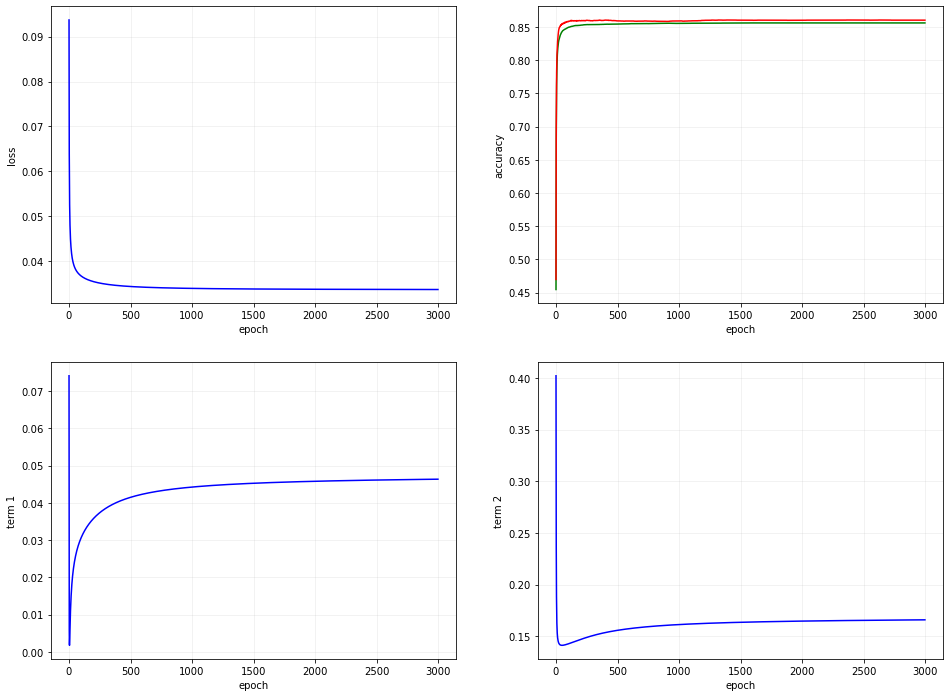

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (16, 12))

axs[0][0].plot(loss_tab, color='blue')
axs[0][1].plot(train_accuracy_tab, color='green')
axs[0][1].plot(test_accuracy_tab, color='red')

axs[1][0].plot(term_I_tab, color = 'blue')
axs[1][1].plot(term_II_tab, color = 'blue')

for row in axs:
    for ax in row:
        ax.grid(True, alpha =0.2)
        ax.set_xlabel('epoch')
        #ax.set_yscale('log')

axs[0][0].set_ylabel('loss')
axs[0][1].set_ylabel('accuracy')
axs[1][0].set_ylabel('term 1')
axs[1][1].set_ylabel('term 2')
plt.show()



## Visualization of mapping of the model

In [13]:
params=[]
for param in model.parameters():
    params.append(param.detach().numpy())
w1=params[0] 
w2=params[1]


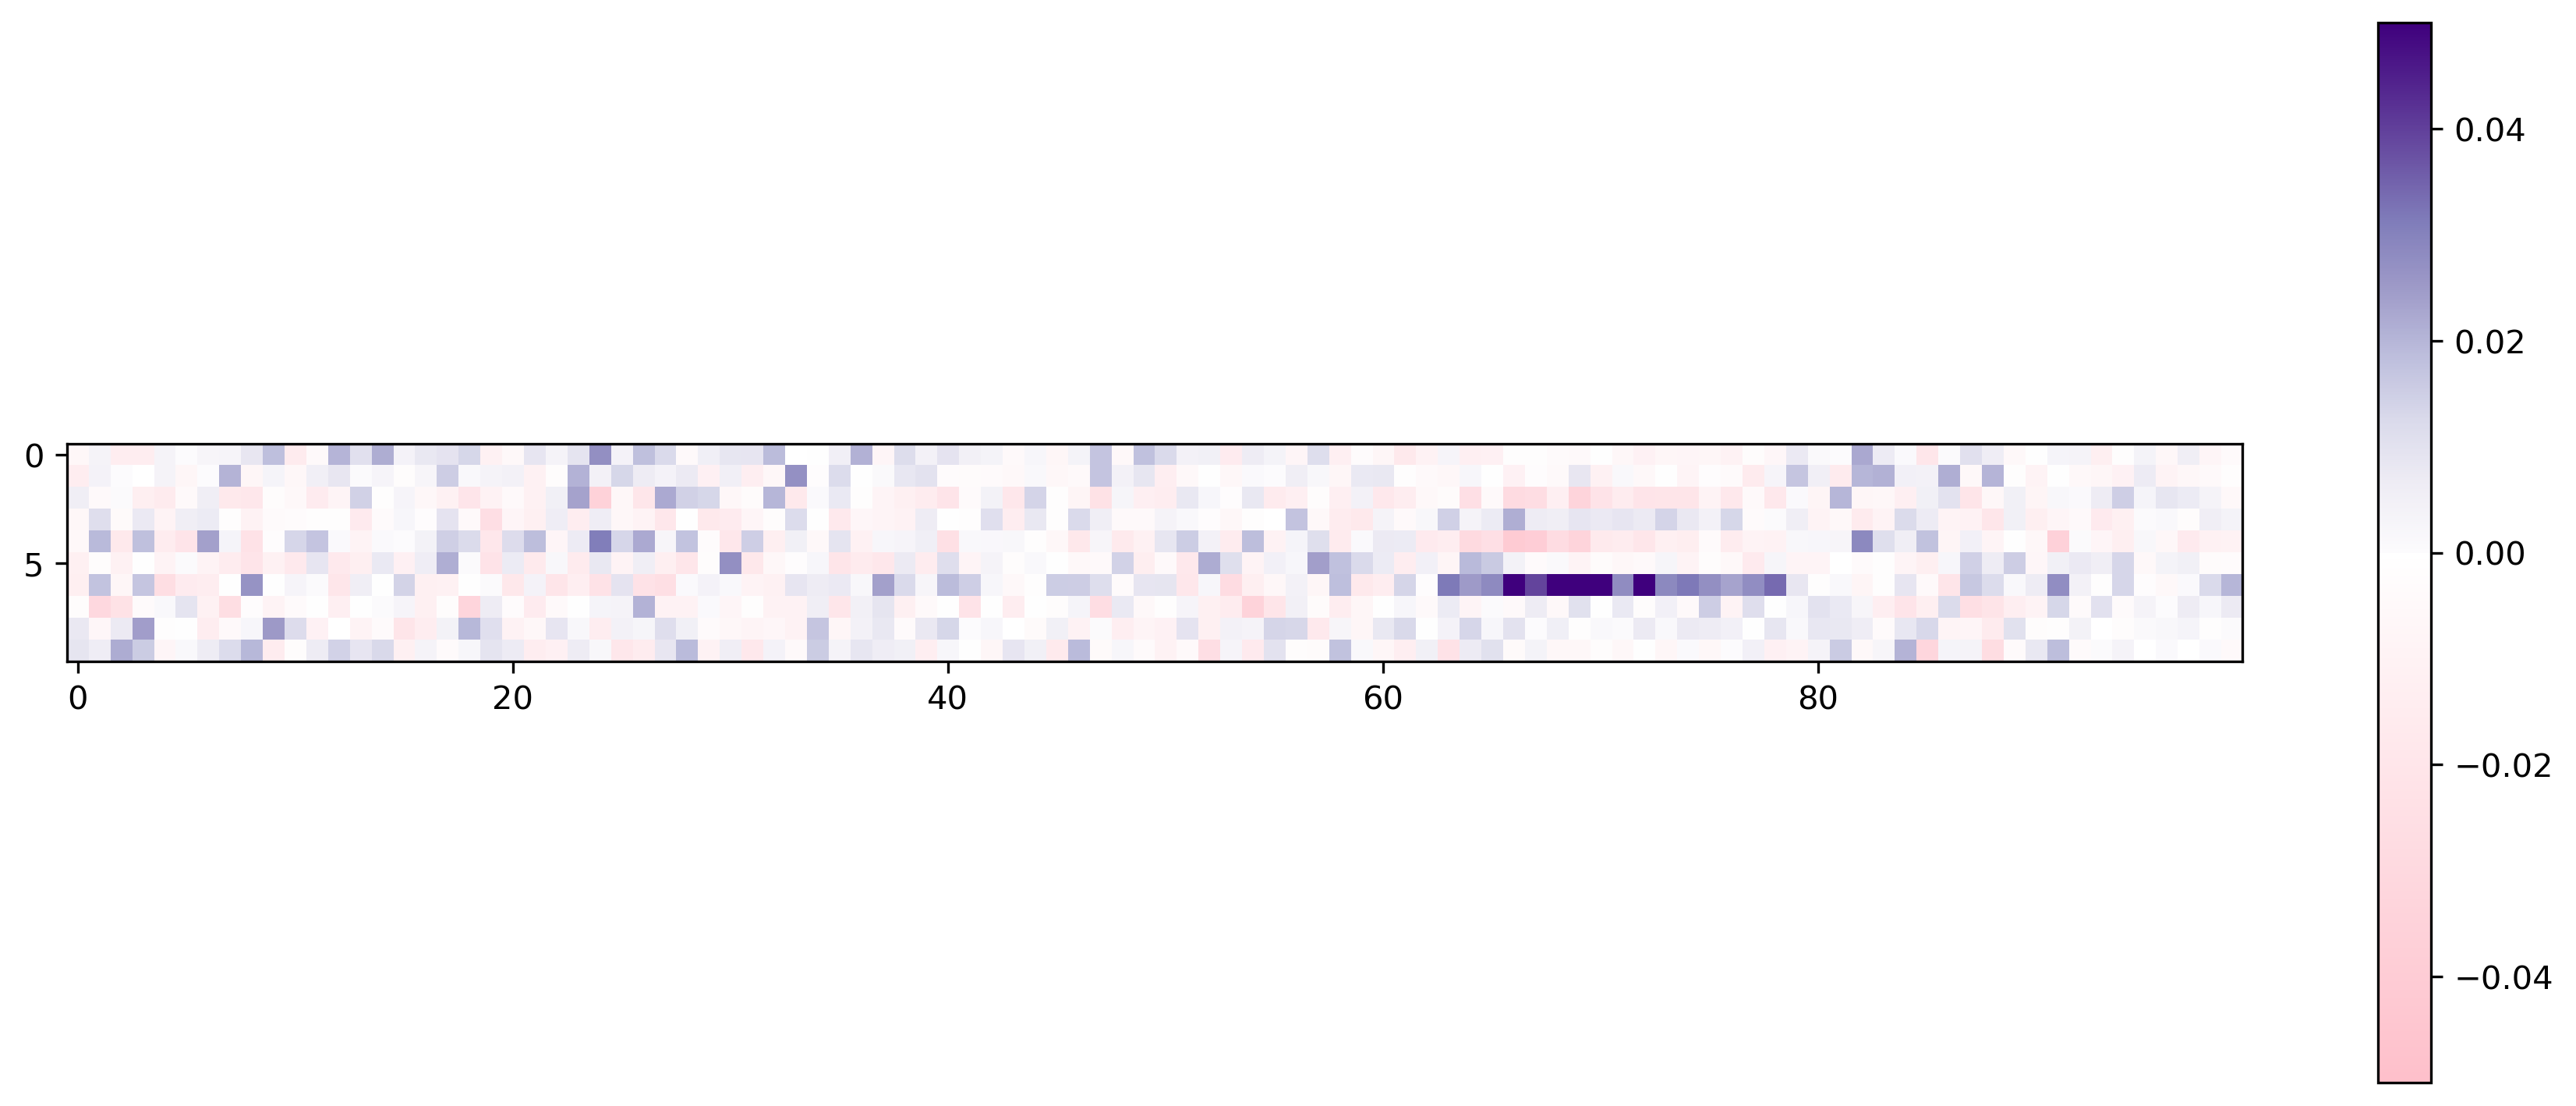

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW =  w2 @ w1 
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


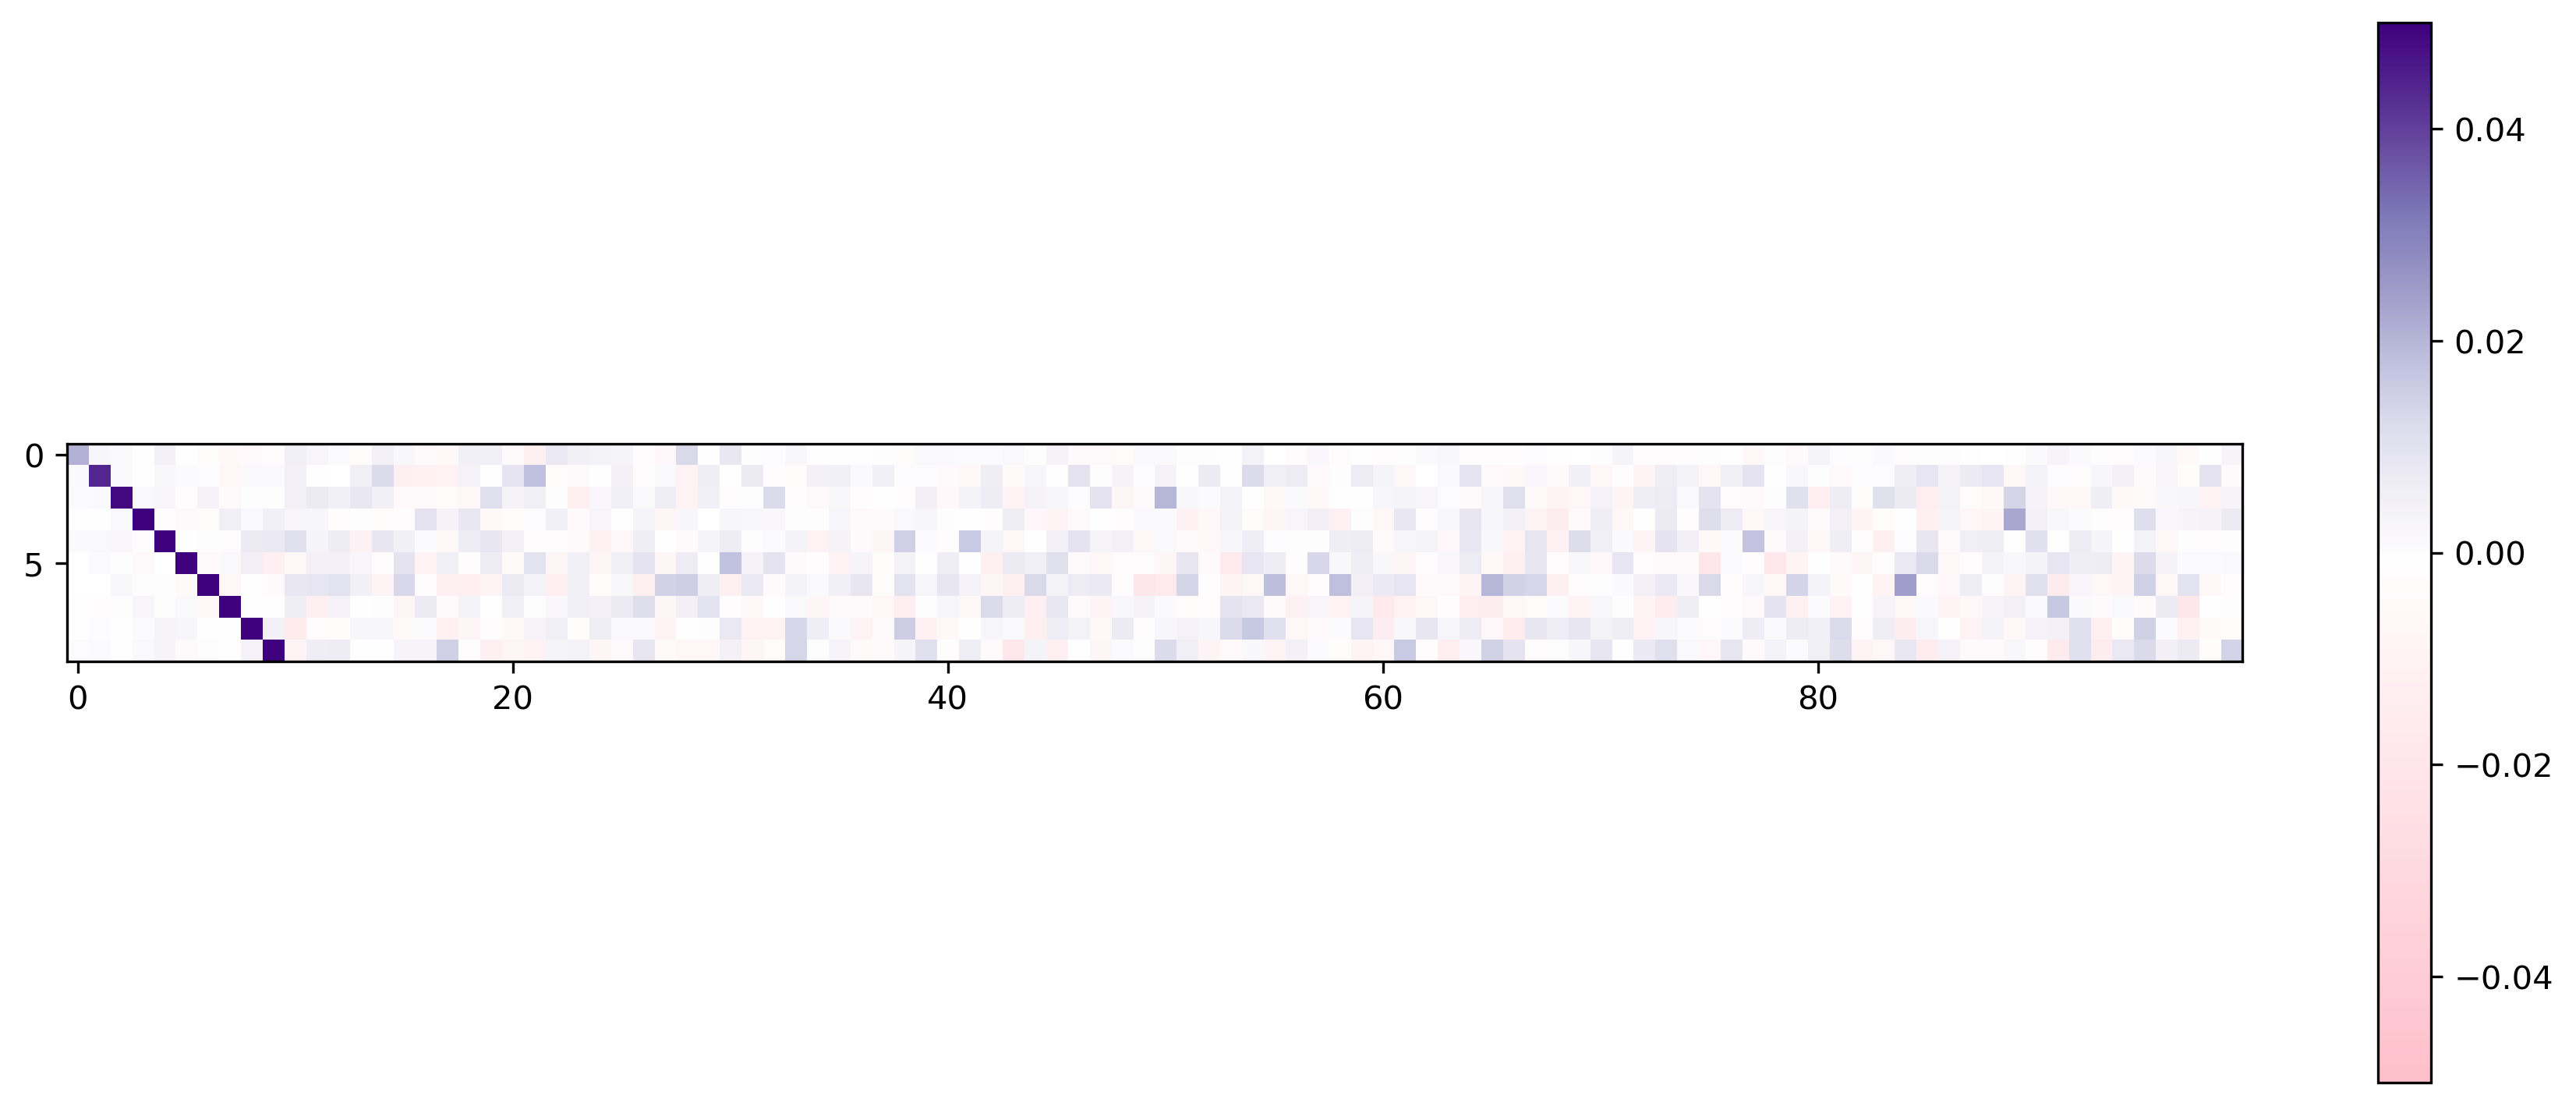

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=300)

WW = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( WW[:100,:100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()


CHECK: $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$
$$ MSE= \frac{1}{P} \sum_{\mu=1}^P \lVert y - W^2 W^1 x \rVert ^2 $$ 

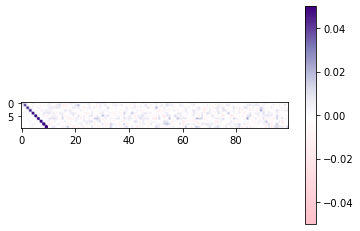

In [16]:
R = U_matrix.T @ w2 @ w1 @ V_matrix
plt.imshow( R[:, :100], cmap = newcmp, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

## Calculation of terms

In [17]:
term_1 = 0
for alpha in range(10):
    term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
term_1



array([0.04635034])

In [18]:
term_2 = 0
for beta in range(10):
    for alpha in range(784):
        if(alpha != beta):
            term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
term_2


0.16604041246495013

In [19]:
term_3 = np.trace(S33_matrix)
term_3

1.000000009

In [20]:
term_4 = 0
for alpha in range(10):
    term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]
term_4   

array([0.49717632])

In [21]:
term_1+term_2+term_3-term_4

array([0.71521445])

In [22]:
term_3-term_4

array([0.50282369])

## terms with star: $T_1^*$,  $T_2^*$,  $T_4^*$

In [23]:
term_4 = 0
for alpha in range(10):
    term_4+= (R[alpha][alpha])**2*S11_matrix[alpha][alpha]
term_4   

0.7859572751115339

In [24]:
term_3-term_4

0.21404273388846617

In [25]:
term_2+term_3-term_4

0.38008314635341633

In [26]:
term_1+term_2+term_3-term_4

array([0.42643349])

# Final MSE on training / testing dataset


In [27]:
MSE_tab=[]
SE_model_tab=[]
SE_calc_tab=[]

batch_size: int = 1  
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [28]:
with torch.no_grad():
    for i, (x,y) in enumerate(train_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc = w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on training set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on training set
MSE = 0.038209 	MSE_model = 0.382091	MSEcalc = 0.382091


In [29]:
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        
        y=F.one_hot(y, num_classes=10).float()
        y_model = model(x)
        
        MSE = criterion(y_model, y)
        SE_model = np.linalg.norm(y_model - y)**2
        
        x=x.detach().numpy().flatten()
        y=y.detach().numpy().flatten()
        
        y_calc =  w2 @ w1 @ x
        SE_calc = np.linalg.norm(y_calc - y)**2

        MSE_tab.append(float(MSE))
        SE_model_tab.append(float(SE_model))
        SE_calc_tab.append(float(SE_calc))

        #print(i,"\tMSE = {:.6f} \tSE_model = {:.6f}\tSEcalc = {:.6f}".format(MSE, SE_model, SE_calc))
        
mean_MSE = sum(MSE_tab)/len(MSE_tab)
mean_SE_model = sum(SE_model_tab)/len(SE_model_tab)
mean_SE_calc = sum(SE_calc_tab)/len(SE_calc_tab)

print("Mean square error evaluated on test set")
print("MSE = {:.6f} \tMSE_model = {:.6f}\tMSEcalc = {:.6f}".format(mean_MSE, mean_SE_model, mean_SE_calc))

Mean square error evaluated on test set
MSE = 0.038220 	MSE_model = 0.382196	MSEcalc = 0.382196


# Save all


In [30]:
import pandas as pd

savefile = 'ground_energy_600.csv'
df = pd.DataFrame()

df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab


df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab
df['R'] = R_tab


df.to_csv(savefile, index=False)

df_w2= pd.DataFrame(np.array(w2_tab).T)
df_w3= pd.DataFrame(np.array(w3_tab).T)

df_w2.to_csv('ground_energy_600_w2.csv', index=False)
df_w3.to_csv('ground_energy_600_w3.csv', index=False)


In [32]:
w1=deepcopy(model.parameters()[0]).detach().numpy().reshape(input_dim*hidden_dim1)
w2=deepcopy(model.parameters()[1]).detach().numpy().reshape(hidden_dim1*output_dim)

df_w1 = pd.DataFrame(w1, columns = ['w1'] )
df_w2 = pd.DataFrame(w2, columns = ['w2'] )

df_w1.to_csv('w1.csv', index=False)
df_w2.to_csv('w2.csv', index=False)
